## Titanic Kaggle Competition

Author: Albert Gallego Jiménez

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the data
datapath = r'D:/Proyectos IA Kaggle/Titanic/data/'

df_train = pd.read_csv(datapath+'train.csv')
df_test = pd.read_csv(datapath+'test.csv')
# there is missing one value from Fare column in test set
df_test.loc[152, 'Fare'] = df_train['Fare'].median()

In [4]:
# See how the data look like
print('Test set shape =', df_test.shape)
print('Train set shape =', df_train.shape)
print('Train df')
df_train.head()

Test set shape = (418, 11)
Train set shape = (891, 12)
Train df


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- PassengerId: ID único para cada pasajero
- Survived: Indica si el pasajero sobrevivió (1) o no (0)
- Pclass: Clase del ticket (1 = Primera clase, 2 = Segunda clase, 3 = Tercera clase)
- Name: Nombre del pasajero
- Sex: Sexo del pasajero (male o female)
- Age: Edad del pasajero en años
- SibSp: Número de hermanos / cónyuges a bordo del Titanic
- Parch: Número de padres / hijos a bordo del Titanic
- Ticket: Número de ticket del pasajero
- Fare: Tarifa pagada por el pasajero
- Cabin: Número de la cabina del pasajero
- Embarked: Puerto de embarque del pasajero (C = Cherbourg, Q = Queenstown, S = Southampton)

In [5]:
df_train['Title'] = df_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df_test['Title'] = df_train.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

In [6]:
combine = [df_train, df_test]
for ds in combine:
    ds['Title'] = ds['Title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Major', 'Rev', 'Sir', 'Lady'], 'Rare')
    ds['Title'] = ds['Title'].replace('Mlle', 'Miss')
    ds['Title'] = ds['Title'].replace('Ms', 'Miss')
    ds['Title'] = ds['Title'].replace('Mme', 'Mrs')

In [7]:
df_train['Title'].value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

In [8]:
df_train[['Title', 'Survived']].groupby(['Title']).mean().sort_values(by='Survived', ascending=False)

,Survived
Title,
Mrs,0.793651
Miss,0.702703
Master,0.575000
Rare,0.347826
Mr,0.156673


### Data preprocessing

Some things to do:
- **Impute** NaN values.
- **Encode** object fields.
- **Normalize** field values.

Pack all these processes in a single **Pipeline** object.


In [9]:
# Detach the train labels (Survived field)
train_labels = pd.DataFrame(df_train['Survived'], columns=['Survived'])

In [10]:
# Remove unnecessary fields
columns_to_drop = ['Survived', 'PassengerId', 'Name', 'Cabin', 'Ticket']

df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop[1::])

In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# Define the imputers
numeric_imputer = SimpleImputer(strategy='median')
encoder = OneHotEncoder(handle_unknown='ignore', sparse=True)
scaler = StandardScaler()

num_attribs = ['Age']
encoder_attribs = ['Pclass', 'Sex', 'Embarked', 'Title']
scaler_attribs = ['Fare']

# Pipeline for the train set and test set
full_pipeline = ColumnTransformer([
            ("numeric_imputer", numeric_imputer, num_attribs),
            ("encoder", encoder, encoder_attribs),
            ("std_scaler", scaler, scaler_attribs)
        ],
)

# Run the pipelines and get the arrays
X_train = full_pipeline.fit_transform(df_train)
X_test = full_pipeline.transform(df_test)
y_train = np.ravel(train_labels)

### Evaluate different models

In [12]:
# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

In [13]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define fold number (k) for the cross-validation
k = 5

# Define a strategy for data splitting
kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

In [14]:
# Logistic Regression
logr = LogisticRegression(random_state=42)
logr.fit(X_train, y_train)
acc = cross_val_score(logr, X_train, y_train, cv=kfold, scoring='accuracy')
acc_logr = round(acc.mean() * 100, 2)
acc_logr

81.04

In [15]:
# Super Vector Machine
svc = SVC()
svc.fit(X_train, y_train)
acc = cross_val_score(svc, X_train, y_train, cv=kfold, scoring='accuracy')
acc_svc = round(acc.mean() * 100, 2)
acc_svc

70.82

In [16]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
random_forest.fit(X_train, y_train)
acc = cross_val_score(random_forest, X_train, y_train, cv=kfold, scoring='accuracy')
acc_random_forest = round(acc.mean() * 100, 2)
acc_random_forest

82.94

In [17]:
# Knn
knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)
acc = cross_val_score(knn, X_train, y_train, cv=kfold, scoring='accuracy')
acc_knn = round(acc.mean() * 100, 2)
acc_knn

75.98

In [18]:
# Gaussian Naive-Bayes
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
acc = cross_val_score(gaussian, X_train, y_train, cv=kfold, scoring='accuracy')
acc_gaussian = round(acc.mean() * 100, 2)
acc_gaussian

79.8

In [19]:
# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
acc = cross_val_score(tree, X_train, y_train, cv=kfold, scoring='accuracy')
acc_tree = round(acc.mean() * 100, 2)
acc_tree

81.14

In [20]:
# ANN
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

keras.backend.clear_session()
np.random.seed(42)

model = keras.Sequential(
    [
        keras.Input(shape=(16)),
        #layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ]
)

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 44,129
Trainable params: 44,129
Non-traina

In [22]:
opt = keras.optimizers.Adam(learning_rate=0.000005)
model.compile(loss="binary_crossentropy",
              optimizer=opt, metrics=["binary_accuracy"])

history = model.fit(X_train, y_train, epochs=2000, batch_size=128,
                    verbose=1)

Epoch 1/2000
7/7 [==============================] - 0s 1ms/step - loss: 0.6776 - binary_accuracy: 0.6476
Epoch 2/2000
7/7 [==============================] - 0s 1ms/step - loss: 0.6704 - binary_accuracy: 0.7104
Epoch 3/2000
7/7 [==============================] - 0s 1ms/step - loss: 0.6640 - binary_accuracy: 0.7632
Epoch 4/2000
7/7 [==============================] - 0s 1ms/step - loss: 0.6584 - binary_accuracy: 0.7217
Epoch 5/2000
7/7 [==============================] - 0s 1ms/step - loss: 0.6539 - binary_accuracy: 0.6891
Epoch 6/2000
7/7 [==============================] - 0s 1ms/step - loss: 0.6502 - binary_accuracy: 0.6689
Epoch 7/2000
7/7 [==============================] - 0s 1ms/step - loss: 0.6472 - binary_accuracy: 0.6543
Epoch 8/2000
7/7 [==============================] - 0s 1ms/step - loss: 0.6448 - binary_accuracy: 0.6465
Epoch 9/2000
7/7 [==============================] - 0s 1ms/step - loss: 0.6430 - binary_accuracy: 0.6431
Epoch 10/2000
7/7 [==============================] - 0s

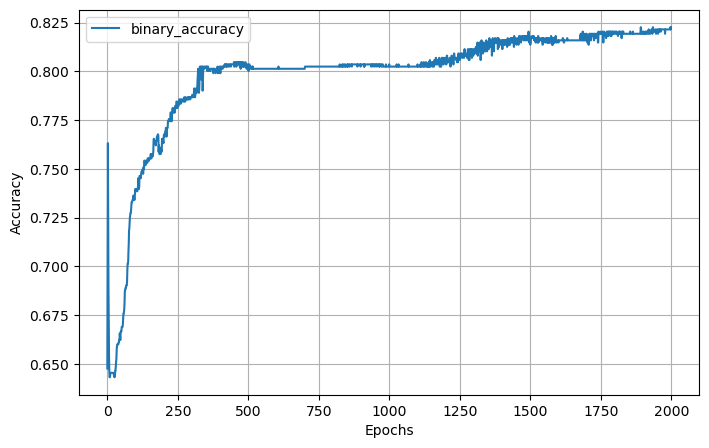

In [23]:
pd.DataFrame(history.history)[['binary_accuracy']].plot(figsize=(8, 5))
plt.xlabel("Epochs"),plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [24]:
acc_ann = round(history.history['binary_accuracy'][-1]*100, 2)
acc_ann

82.27

In [25]:
# Check all accuracies
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Decision Tree', 'ANN'],
    'Train Acc Score': [acc_svc, acc_knn, acc_logr, acc_random_forest,
              acc_gaussian, acc_tree, acc_ann]})
models.sort_values(by='Train Acc Score', ascending=False)

,Model,Train Acc Score
3,Random Forest,82.94
6,ANN,82.27
5,Decision Tree,81.14
2,Logistic Regression,81.04
4,Naive Bayes,79.80
1,KNN,75.98
0,Support Vector Machines,70.82


### Evaluate the test set and check the accuracy

In [26]:
# Load the test labels
y_test = np.ravel(pd.read_csv(datapath+'gender_submission.csv').drop(columns=['PassengerId']))

In [27]:
# Evaluate the best model
y_pred = random_forest.predict(X_test)

Save a csv file with the predictions to make the submission

In [28]:
'''
file_to_submit = pd.read_csv(datapath+'gender_submission.csv')
file_to_submit['Survived'] = y_pred.astype(int)
file_to_submit.to_csv('file_to_submit_v2.csv', index=False)
'''

"\nfile_to_submit = pd.read_csv(datapath+'gender_submission.csv')\nfile_to_submit['Survived'] = y_pred.astype(int)\nfile_to_submit.to_csv('file_to_submit_v2.csv', index=False)\n"